In [1]:
import matplotlib.pyplot as plt 
import string
import os
import re
import shutil

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
tf.__version__

'2.4.1'

**Sentiment Classification**

Classify movie reviews as positive or negative. 50,000 movie reviews, train and test split of 25,000 each.

**Downloading the dataset**

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84131840/84125825 [==============================] - 3s 0us/step


In [4]:
os.listdir(dataset_dir)

['train', 'README', 'test', 'imdb.vocab', 'imdbEr.txt']

In [5]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['unsup',
 'unsupBow.feat',
 'urls_unsup.txt',
 'pos',
 'labeledBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'neg']

In [6]:
sample_file = os.path.join(train_dir,"pos/1181_9.txt")
with open(sample_file) as f:
  print (f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

**Load the dataset**

text_dataset_from_directory can be used if the structure is Main_directory -> class A -> a1.txt, a2.txt

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory("aclImdb/train",batch_size=batch_size,validation_split=0.2,subset='training',seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(3):
    print (text_batch[i])
    print (label_batch[i])

tf.Tensor(b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with cha

In [10]:
raw_train_ds.class_names

['neg', 'pos']

In [11]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory("aclImdb/train",batch_size=batch_size,validation_split=0.2,subset='validation',seed=seed)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory("aclImdb/test",batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


**Data Preprocessing** : 

Standardize, vectorize and tokenize the data.

Standardize - Removing punctuation or html elements.

Tokenization - Splitting strings to tokens

Vectorization - Converting tokens to numerical vectors

In [12]:
def custom_standardization(text):

  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text,'<br /',' ')
  text = tf.strings.regex_replace(text,'[%s]' % re.escape(string.punctuation),'')
  return text

max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(standardize=custom_standardization, max_tokens=max_features, output_mode='int', output_sequence_length=sequence_length)

In [13]:
# fit the state of the prepreocessor
train_text = raw_test_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [14]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [15]:
train_ds = raw_train_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

**Configure the dataset for performance**

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Creating a Model**



After Embedding dimension we get a (batch,seq_length,embedding)

In [18]:
embedding_dim = 16

model = tf.keras.Sequential([
                
                layers.Embedding(max_features+1,embedding_dim),
                layers.Dropout(0.2),
                layers.GlobalAveragePooling1D(),
                layers.Dropout(0.2),
                layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [24]:
epochs = 10

history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2257 - binary_accuracy: 0.9180 - val_loss: 0.2950 - val_binary_accuracy: 0.8756
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2153 - binary_accuracy: 0.9222 - val_loss: 0.2935 - val_binary_accuracy: 0.8758
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2056 - binary_accuracy: 0.9268 - val_loss: 0.2926 - val_binary_accuracy: 0.8776
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1953 - binary_accuracy: 0.9316 - val_loss: 0.2930 - val_binary_accuracy: 0.8770
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1872 - binary_accuracy: 0.9345 - val_loss: 0.2941 - val_binary_accuracy: 0.8790
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1799 - binary_accuracy: 0.9381 - val_loss: 0.2956 - val_binary_accuracy: 0.8794
Epoch 7/10
625/625 [==============================] - 4s 7ms/ste

In [25]:
loss,accuracy = model.evaluate(test_ds)
print (loss)
print (accuracy)

782/782 [==============================] - 1s 1ms/step - loss: 0.3329 - binary_accuracy: 0.8693
0.3328828513622284
0.8692799806594849


model stores the losses in the history

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

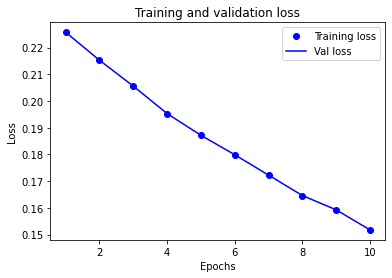

In [29]:
acc= history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,loss,'b',label='Val loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

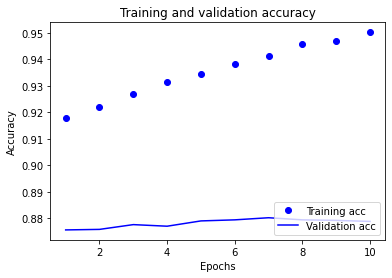

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 13ms/step - loss: 0.3325 - accuracy: 0.8699
0.8692799806594849


In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6975673 ],
       [0.45039564],
       [0.3449934 ]], dtype=float32)